#Install and import library

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 163 kB 66.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 


In [2]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=f7cb2f96b2358a97887f3f786440ef7f230eb13e06ce7657eeb16066c7bf56d6
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [3]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-10-08 04:54:32--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2022-10-08 04:54:32 (179 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-10-08 04:54:32--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [4]:
from google.colab import drive
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

#Load Data

In [5]:
def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels, columns = labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

##Load Dataset (UIT-VSMEC)

In [7]:
df_train= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Data/train_nor_811.xlsx')
df_test= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Data/test_nor_811.xlsx')
df_valid= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Data/valid_nor_811.xlsx')

In [8]:
df_train= df_train.dropna(subset=['Sentence'])
df_test= df_test.dropna(subset=['Sentence'])
df_valid= df_valid.dropna(subset=['Sentence'])

##Train

In [9]:
X_train1= df_train.loc[:,'Sentence']
X_train1

0                   cho mình xin bài nhạc tên là gì với ạ
1       cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2       lo học đi . yêu đương lol gì hay lại thích học...
3         uớc gì sau này về già vẫn có thể như cụ này :))
4       mỗi lần có video của con là cứ coi đi coi lại ...
                              ...                        
5543    đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544                               nhìn mặt héo queo luôn
5545    tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546                      thích thân hình boss rồi nhan 😌
5547    ước mơ nhỏ nhoi của tao là được làm chị mà khô...
Name: Sentence, Length: 5548, dtype: object

In [10]:
y_train= df_train.loc[:,'Emotion']
y_train

0           Other
1         Disgust
2         Disgust
3       Enjoyment
4       Enjoyment
          ...    
5543      Disgust
5544        Other
5545        Other
5546    Enjoyment
5547      Sadness
Name: Emotion, Length: 5548, dtype: object

In [11]:
#Encode y_train

enc1 = LabelEncoder()
y_train = enc1.fit_transform(y_train)

In [12]:
enc1.classes_

array(['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness',
       'Surprise'], dtype=object)

In [13]:
y_train= pd.Series(y_train)
y_train

0       4
1       1
2       1
3       2
4       2
       ..
5543    1
5544    4
5545    4
5546    2
5547    5
Length: 5548, dtype: int64

##Test

In [14]:
X_test1= df_test.loc[:,'Sentence']
X_test1

0                       người ta có bạn bè nhìn vui thật
1              cho nghỉ viêc mói đúng sao goi là kỷ luật
2                                             kinh vãi 😡
3      nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4          bố không thích nộp đấy mày thích ý kiến không
                             ...                        
688    lúc thì cuốc đất è cổ ra không có giun mà câu ...
689    các bác dẫn crush qua cây sữa nay mà hứng nước...
690    vợ chồng rồi mà trong sáng như này chỉ có tron...
691                     bep này vào binh dương dùng xuất
692                                 đôi mắt đằm thắm vãi
Name: Sentence, Length: 693, dtype: object

In [15]:
y_test= df_test.loc[:,'Emotion']
y_test

0        Sadness
1       Surprise
2        Disgust
3           Fear
4          Anger
         ...    
688      Sadness
689    Enjoyment
690     Surprise
691        Other
692     Surprise
Name: Emotion, Length: 693, dtype: object

In [16]:
#Encode y_test

enc2 = LabelEncoder()
y_test = enc2.fit_transform(y_test)

In [17]:
y_test= pd.Series(y_test)
y_test

0      5
1      6
2      1
3      3
4      0
      ..
688    5
689    2
690    6
691    4
692    6
Length: 693, dtype: int64

##Dev

In [18]:
X_valid1= df_valid.loc[:,'Sentence']
X_valid1

0      tính tao tao biết , chẳng có chuyện gì có thể ...
1               lại là lào cai , tự hào quê mình quá :))
2                                         bị từ chối rồi
3                             tam đảo trời đẹp các mem à
4      đọc bình luận của thằng đó không thiếu chữ nào 😂😂
                             ...                        
681                                       nhọc lòng :(((
682    tao đã rất muốn làm bạn tốt anh em tri kỉ với ...
683                     cơm tấm ở ngoài cũng như này . 😡
684                                   chất liệu đỉnh quá
685    dume lũ mất dạy . bố mẹ cho mày ăn học để dơ n...
Name: Sentence, Length: 686, dtype: object

In [19]:
y_valid= df_valid.loc[:,'Emotion']
y_valid

0          Other
1      Enjoyment
2        Sadness
3      Enjoyment
4          Other
         ...    
681      Sadness
682      Sadness
683      Disgust
684     Surprise
685        Anger
Name: Emotion, Length: 686, dtype: object

In [20]:
#Encode y_valid

enc3 = LabelEncoder()
y_valid = enc3.fit_transform(y_valid)

In [21]:
y_valid= pd.Series(y_valid)
y_valid

0      4
1      2
2      5
3      2
4      4
      ..
681    5
682    5
683    1
684    6
685    0
Length: 686, dtype: int64

#Emolex
Load data after commbined UIT-VSMEC with VnEmolex

In [23]:
df_train2= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Lexicon/count_sentiment_train.xlsx')
df_test2= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Lexicon/count_sentiment_test.xlsx')
df_valid2= pd.read_excel('/content/drive/MyDrive/DoAnTotNghiep/Lexicon/count_sentiment_val.xlsx')

In [24]:
X_train2= df_train2[['Anger', 'Disgust', 'Enjoyment']].values
X_train2

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 2],
       ...,
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [25]:
X_test2= df_test2[['Anger', 'Disgust', 'Enjoyment']].values
X_test2

array([[0, 0, 3],
       [0, 0, 1],
       [0, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0]])

In [26]:
X_valid2= df_test2[['Anger', 'Disgust', 'Enjoyment']].values
X_valid2

array([[0, 0, 3],
       [0, 0, 1],
       [0, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0]])

#Pre-process

In [27]:
STOPWORDS= '/content/drive/MyDrive/DoAnTotNghiep/File backup/vietnamese-stopwords-dash.txt'
# You can download VietNamese Stopwords at: https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords-dash.txt 

In [28]:
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [29]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    #text = filter_stop_words(text, stopwords)
    #text = deEmojify(text)
    #text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        #sentences = vncorenlp.tokenize(text)
        for sentence in text:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = np.array(X)
    y = np.array(y)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [30]:
train_X, train_y = pre_process_features(X_train1, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_valid1, y_valid, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test1, y_test, tokenized=True, lowercased = False)

#XLMR

In [31]:
model = AutoModelForSequenceClassification.from_pretrained( 'xlm-roberta-large', num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large', use_fast=False)

Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [32]:
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

##Convert

In [ ]:
len(test_encodings['input_ids'][1])

100

###We adapt the modifications based on the length of the "input_ids"
###Train, test, dev have different "input_ids" length

###'input_ids'

In [33]:
for i in range(0,len(train_encodings['input_ids'])):
  for j in range(98,100):
    train_encodings['input_ids'][i][j]= X_train2[i][j-98]

In [34]:
for i in range(0,len(test_encodings['input_ids'])):
  for j in range(79,81):
    test_encodings['input_ids'][i][j]= X_test2[i][j-79]

In [35]:
for i in range(0,len(dev_encodings['input_ids'])):
  for j in range(91,93):
    dev_encodings['input_ids'][i][j]= X_valid2[i][j-91]

#Training

In [36]:
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

OUTPUT_DIR = '/content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT'

training_args = TrainingArguments(
    output_dir= OUTPUT_DIR,          
    num_train_epochs=4,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    #warmup_steps=500,                
    #weight_decay=0.01,
    learning_rate = 1e-5,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5548
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1388


Step,Training Loss
500,1.552600
1000,0.988100


Saving model checkpoint to /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-500
Configuration saved in /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-1000
Configuration saved in /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/DoAnTotNghiep/Saved/phoBERT/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1388, training_loss=1.1340292235272762, metrics={'train_runtime': 1725.562, 'train_samples_per_second': 12.861, 'train_steps_per_second': 0.804, 'total_flos': 4039408243324800.0, 'train_loss': 1.1340292235272762, 'epoch': 4.0})

In [37]:
y_pred_classify = trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
#cf = confusion_matrix(y_test, y_pred)
#df_cm = pd.DataFrame(cf, index = labels, columns = labels)
#sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred))

***** Running Prediction *****
  Num examples = 693
  Batch size = 16


F1 - micro: 0.6652236652236653
F1 - macro: 0.6207256269590256
Accuracy: 0.6652236652236653


In [38]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.4000    0.4444        40
           1     0.6324    0.6515    0.6418       132
           2     0.7340    0.7720    0.7525       193
           3     0.6078    0.6739    0.6392        46
           4     0.6102    0.5581    0.5830       129
           5     0.7395    0.7586    0.7489       116
           6     0.5588    0.5135    0.5352        37

    accuracy                         0.6652       693
   macro avg     0.6261    0.6182    0.6207       693
weighted avg     0.6613    0.6652    0.6624       693



Text(0.5, 92.09999999999997, 'Predicted')

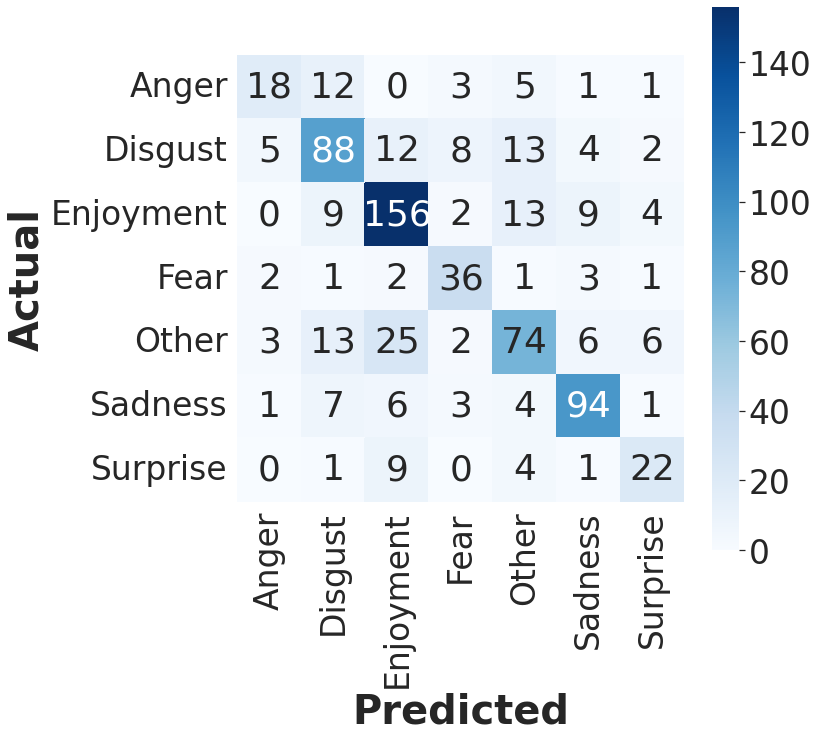

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.set(font_scale=3)
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'g',xticklabels=['Anger','Disgust','Enjoyment','Fear','Other','Sadness','Surprise'], yticklabels=['Anger','Disgust','Enjoyment','Fear','Other','Sadness','Surprise'])
#ax.set_title('XLM-R Confussion matrix')
ax.set_ylabel('Actual', fontsize=40 ,fontweight = 'bold')
ax.set_xlabel('Predicted', fontsize=40, fontweight = 'bold')

#PhoBERT

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained( 'roberta-base', num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "